In [298]:
import pandas as pd
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
import librosa


In [299]:
import warnings
warnings.filterwarnings('ignore')

#### Technical

In [313]:
# name = "01_technical"
# motion_name = "01_technical.csv"
# midi_name = "01_technical_segm.csv"
# correctness_name = "01_technical_segm_correctness.csv"

name = "02_technical"
motion_name = "02_technical.csv"
midi_name = "02_technical_segm.csv"
correctness_name = "02_technical_segm_correctness.csv"

df_motion = pd.read_csv("./Materials_/"+motion_name)
df_midi = pd.read_csv("./Materials_/"+midi_name)
df_correctness = pd.read_csv("../NoteCorrectness/"+correctness_name)
df_metadata = pd.read_csv("./Materials_/metadata_copy.csv")

In [314]:
framerate = 240
if df_motion.loc[1,"Time (ms)"]-df_motion.loc[0,"Time (ms)"] == 4:
    framerate = 250

In [315]:
## find parts
def get_parts(parts):
    tmp = parts.split(".")
    parts = {}
    for l in tmp:
        l = l.split(" ")
        parts[l[0]] = [int(l[1]), int(l[2])]
        
    return parts

LH_parts = df_metadata[ (df_metadata["motion"] == motion_name) ]["LH parts"].values[0]
RH_parts = df_metadata[ (df_metadata["motion"] == motion_name) ]["RH parts"].values[0]



In [316]:
LH_parts = get_parts(LH_parts)
RH_parts = get_parts(RH_parts)

#### Retrieve Articulation

In [317]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

In [318]:
color_dict = {
    "Legato": "black",
    "Staccato": "black",
    "Non Legato": "black",
    "Pause": "violet",
}

linewidth_dict = {
    "Legato": 10,
    "Staccato": 4,
    "Non Legato": 4,
    "Pause": 5,
}

linetype_dict = {
    "Legato": '-',
    "Staccato": ':',
    "Non Legato": '--',
    "Pause": '-',    
}

In [319]:
def find_articulation_technical(df, name, 
                      legato_threshold_ms = 10,
                     staccato_threshold_ms = 20,
                     non_legato_threshold_ms = 30):
    
    df_articulation_stats = pd.DataFrame(columns = [
    "Name", "Hand", "Type", 'Start Time', 'End Time', 'Notes'] 
    )
    
    df_init = df.copy(deep=True)
    
    legato_threshold_frames = int(legato_threshold_ms*1000/240)
    staccato_threshold_frames = int(staccato_threshold_ms*1000/240)
    non_legato_threshold_frames = int(non_legato_threshold_ms*1000/240)
    
    
    for hand in ["LH","RH"]:

        df = df_init[df_init["Hand"]==hand]
        df.reset_index(inplace=True, drop=True)
        rows = df.shape[0]
    
        seq = []
    
        for index, row in df.iterrows():
            if row['Measure']!= 0 and index < rows-1:

                start_curr = row['Start Midi']
                end_curr = row['End Midi']

                start_next = df.loc[index+1,'Start Midi']
                end_next = df.loc[index+1,'End Midi']

                if end_curr > start_next - legato_threshold_frames: 
                    df_articulation_stats = df_articulation_stats.append({
                            "Name": name,
                            "Hand": hand,
                            "Type": "Legato",
                            "Start Time": start_curr,
                            "End Time": start_next,
                            "Notes" : " ".join(seq)
                            }, ignore_index=True) 

                elif end_curr > start_next - staccato_threshold_frames:  
                    df_articulation_stats = df_articulation_stats.append({
                        "Name": name,
                        "Hand": hand,
                        "Type": "Staccato",
                        "Start Time": start_curr,
                        "End Time": start_next,
                        "Notes" : " ".join(seq)
                        }, ignore_index=True)     

                elif end_curr > start_next - non_legato_threshold_frames:  
                    df_articulation_stats = df_articulation_stats.append({
                        "Name": name,
                        "Hand": hand,
                        "Type": "Non Legato",
                        "Start Time": start_curr,
                        "End Time": start_next,
                        "Notes" : " ".join(seq)
                        }, ignore_index=True) 
                else:
                    df_articulation_stats = df_articulation_stats.append({
                        "Name": name,
                        "Hand": hand,
                        "Type": "Pause",
                        "Start Time": start_curr,
                        "End Time": start_next,
                        "Notes" : " ".join(seq)
                        }, ignore_index=True) 

    df_articulation_stats.to_csv(("./statistics/"+name+"_legato_threshold"+str(legato_threshold_ms)+
                            "_staccato_threshold"+str(staccato_threshold_ms)+"_non_legato_threshold"+
                            str(non_legato_threshold_ms)+"_articulation_stats.csv")) 
    
    
    return df_articulation_stats

In [320]:
def print_articulation_technical(df_art, df_mid, 
                                 color_dict, linewidth_dict, 
                                 linetype_dict):
    

    sns.set(rc={'figure.figsize':(60,19)},font_scale=6)
    sns.set_style("whitegrid", {'font.family':'serif', 'font.serif':'Times New Roman'})
    
    df_mid = df_mid[df_mid['Measure']!=0]
    
    df_art_rh = df_art[df_art["Hand"]=="RH"] 
    df_art_lh = df_art[df_art["Hand"]=="LH"] 
    
    df_mid_rh = df_mid[df_mid["Hand"]=="RH"] 
    df_mid_lh = df_mid[df_mid["Hand"]=="LH"]   
    
    
    
    for key, value in RH_parts.items():    
    
        fig, ax = plt.subplots()
        plt.rcParams.update()
        start_rh = value[0]
        end_rh = value[1]
        
        df_art_rh_part = df_art_rh[df_art_rh['Start Time']>=start_rh]
        df_art_rh_part = df_art_rh_part[df_art_rh_part['End Time']<=end_rh]
        
        df_mid_rh_part = df_mid_rh[df_mid_rh['Start Midi']>=start_rh]
        df_mid_rh_part = df_mid_rh_part[df_mid_rh_part['Start Midi']<=end_rh]
        
        start_lh = LH_parts["LH"+key[2:]][0]
        end_lh = LH_parts["LH"+key[2:]][1]
        
        df_art_lh_part = df_art_lh[df_art_lh['Start Time']>=start_lh]
        df_art_lh_part = df_art_lh_part[df_art_lh_part['End Time']<=end_lh]    
    
        df_mid_lh_part = df_mid_lh[df_mid_lh['Start Midi']>=start_lh]
        df_mid_lh_part = df_mid_lh_part[df_mid_lh_part['Start Midi']<=end_lh]   
        
        start_frame = min(df_mid_lh_part['Start Midi'].values[0], df_mid_rh_part['Start Midi'].values[0])
        
        
        df_mid_lh_part['Start Midi'] -= start_frame
        df_mid_lh_part['End Midi'] -= start_frame
        df_mid_rh_part['Start Midi'] -= start_frame
        df_mid_rh_part['End Midi'] -= start_frame
        
        df_art_lh_part['Start Time'] -= start_frame
        df_art_lh_part['End Time'] -= start_frame
        df_art_rh_part['Start Time'] -= start_frame
        df_art_rh_part['End Time'] -= start_frame

        
        remove = []
        for index, row in df_art_lh_part.iterrows():
        
            start = int(row["Start Time"])
            end = int(row["End Time"])

            x = [i/framerate for i in range(start,end+1)]
            y = ["LH" for _ in range(start,end+1)]
            
            if row["Type"] == "Pause":
                remove.append(end)
            else:
                if row["Type"] == "Non Legato":
                    plt.plot(x, y, linetype_dict[row["Type"]], label = row["Type"],dashes=(4, 2),
                           color = color_dict[row["Type"]], linewidth=1.2*linewidth_dict[row["Type"]],zorder=5)
                else:
                    plt.plot(x, y, linetype_dict[row["Type"]], label = row["Type"],
                           color = color_dict[row["Type"]], linewidth=1.2*linewidth_dict[row["Type"]],zorder=5)
    
        for index, row in df_mid_lh_part.iterrows():
            if row['Start Midi'] not in remove:
                plt.scatter(row['Start Midi']/framerate, "LH", edgecolors='black',linewidth=2,
                            color="gray", s=1000, zorder=10)    
        
        remove = []
        for index, row in df_art_rh_part.iterrows():
        
            start = int(row["Start Time"])
            end = int(row["End Time"])

            x = [i/framerate for i in range(start,end+1)]
            y = ["RH" for _ in range(start,end+1)]
            
            if row["Type"] == "Pause":
                remove.append(end)
            else:
                if row["Type"] == "Non Legato":
                    plt.plot(x, y, linetype_dict[row["Type"]], label = row["Type"],
                           color = color_dict[row["Type"]], dashes=(4, 2),
                         linewidth=1.2*linewidth_dict[row["Type"]],zorder=5)
                else:
                    plt.plot(x, y, linetype_dict[row["Type"]], label = row["Type"],
                           color = color_dict[row["Type"]], 
                         linewidth=1.2*linewidth_dict[row["Type"]],zorder=5)
    
        for index, row in df_mid_rh_part.iterrows():
            if row['Start Midi'] not in remove:
                plt.scatter(row['Start Midi']/framerate, "RH", edgecolors='black',linewidth=2,
                            color="gray", s=1000, zorder=10)
        
        notes = df_mid_rh_part["Note"].values
        notes = [librosa.note_to_hz(n) for n in notes]
        highest_note = librosa.hz_to_note(max(notes))

        highest_note_index = df_mid_rh_part[df_mid_rh_part["Note"] == highest_note].index[0]
        start_frame_highest_note = df_mid_rh_part[df_mid_rh_part["Note"] == highest_note]["Start Midi"].values[0]
        plt.axvline(x = start_frame_highest_note/framerate, color = "black")

        plt.text(x= (start_frame_highest_note-130)/framerate, 
                 y=1.4, s="Asc")
        plt.text(x= (start_frame_highest_note+15)/framerate, 
                 y=1.4, s="Desc")
        
        plt.title("Articulation - "+str(key[3:]) +" (Pianist " + name[1] + ")", y =1.08)
        plt.xlabel('Time (sec)')

        plt.ylim(-0.8,2)
        ax.yaxis.grid(False) # Hide the horizontal gridlines
        ax.xaxis.grid(False) # Show the vertical gridlines
        ax.set_yticks(["RH", "LH"], fontsize=16)
        ax.set_yticklabels(labels= ["RH", "LH"], x=0)
        ax.legend()

        legend_without_duplicate_labels(ax)

        plt.savefig("./plots/articulation/articulation_"+ name+ "_"+str(key[3:])+".png")
        plt.show()
        plt.close()    
    
    

In [321]:
if "technical" in name:
    df_articulation_technical = find_articulation_technical(df_midi, name, 
                      legato_threshold_ms = 10,
                     staccato_threshold_ms = 20,
                     non_legato_threshold_ms = 50)

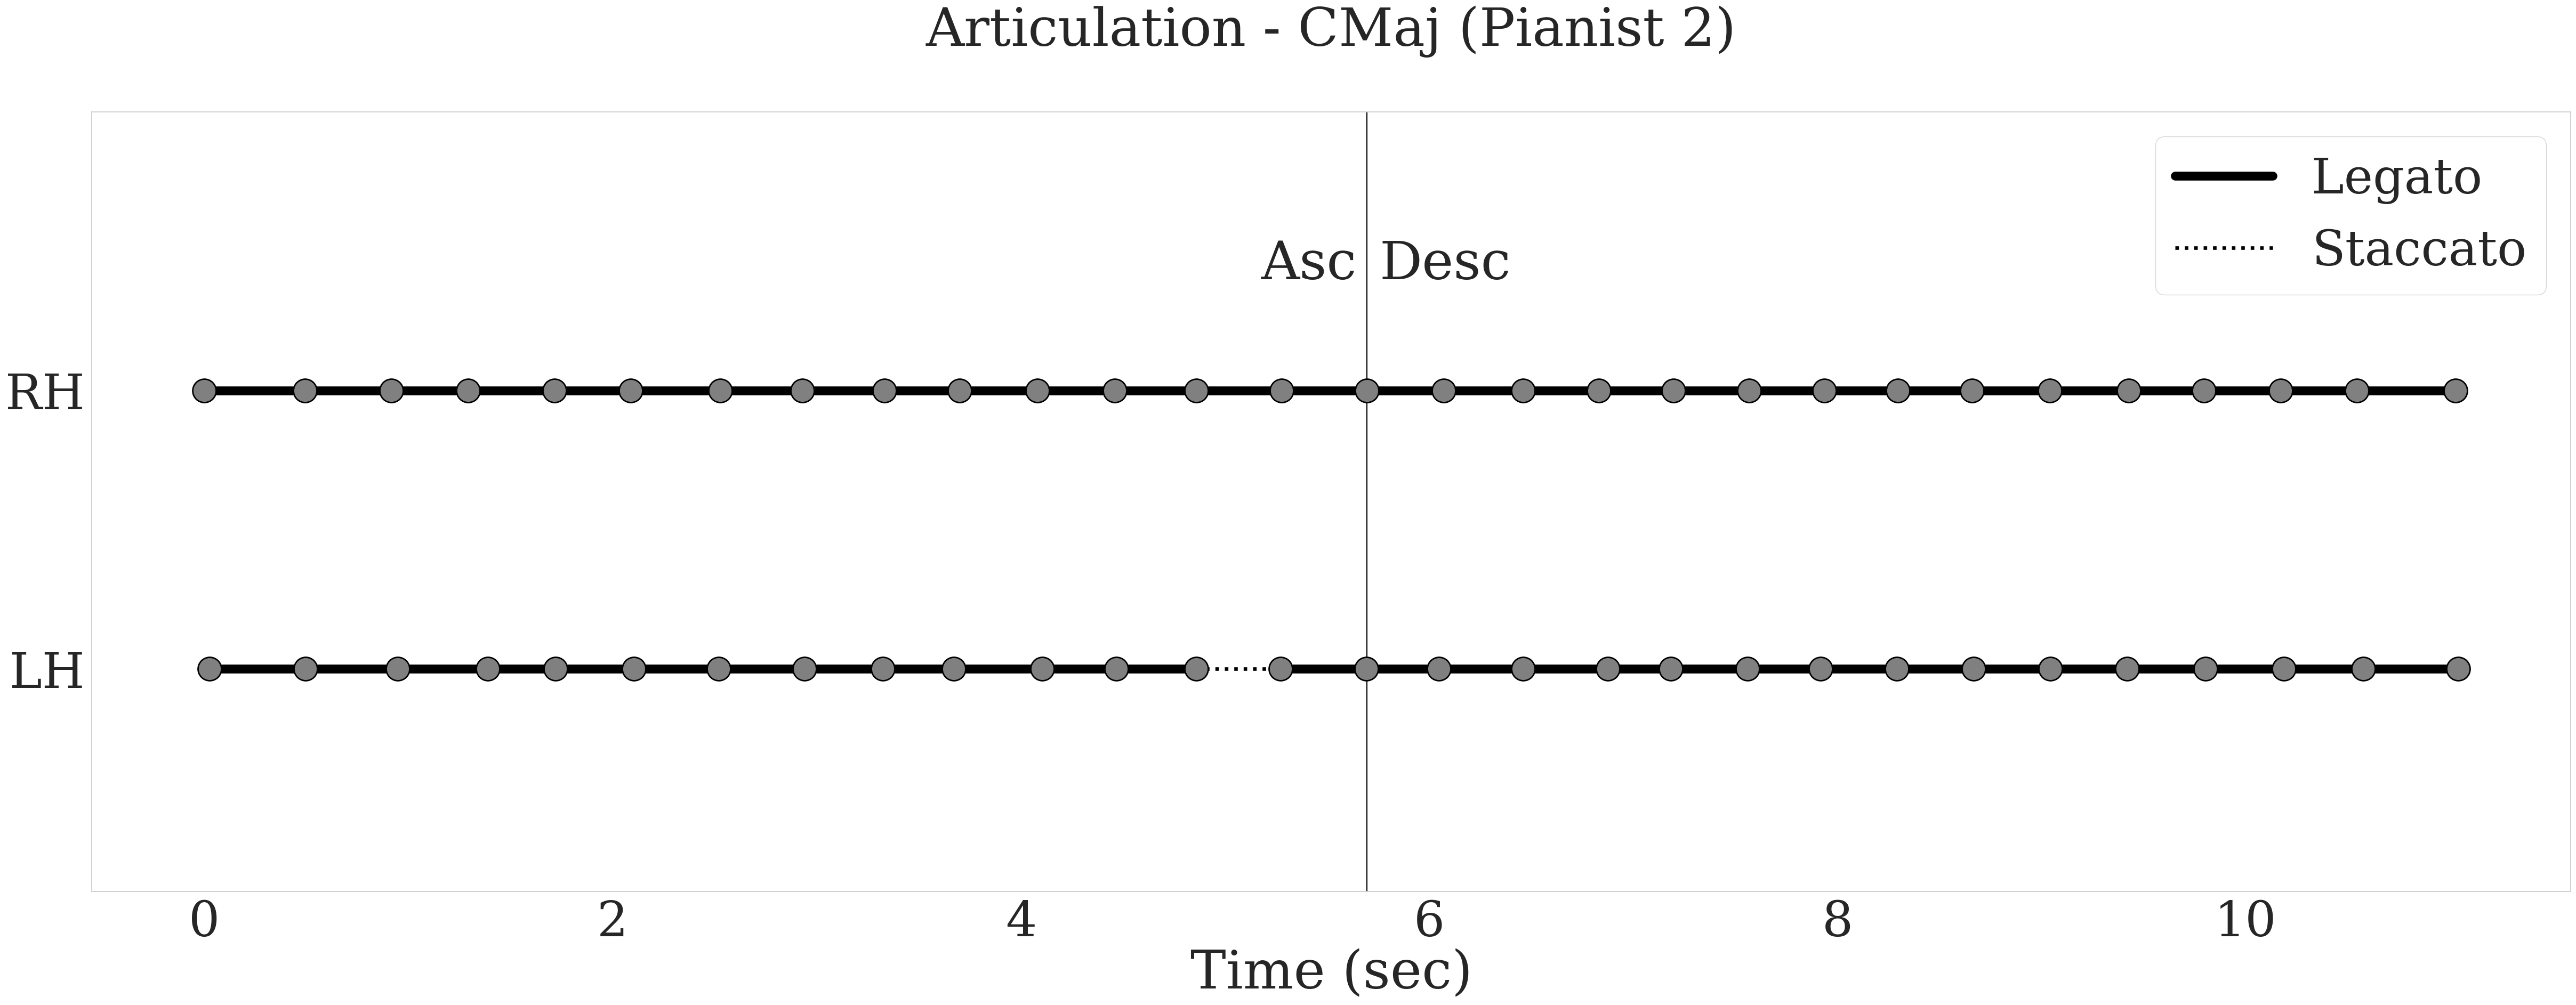

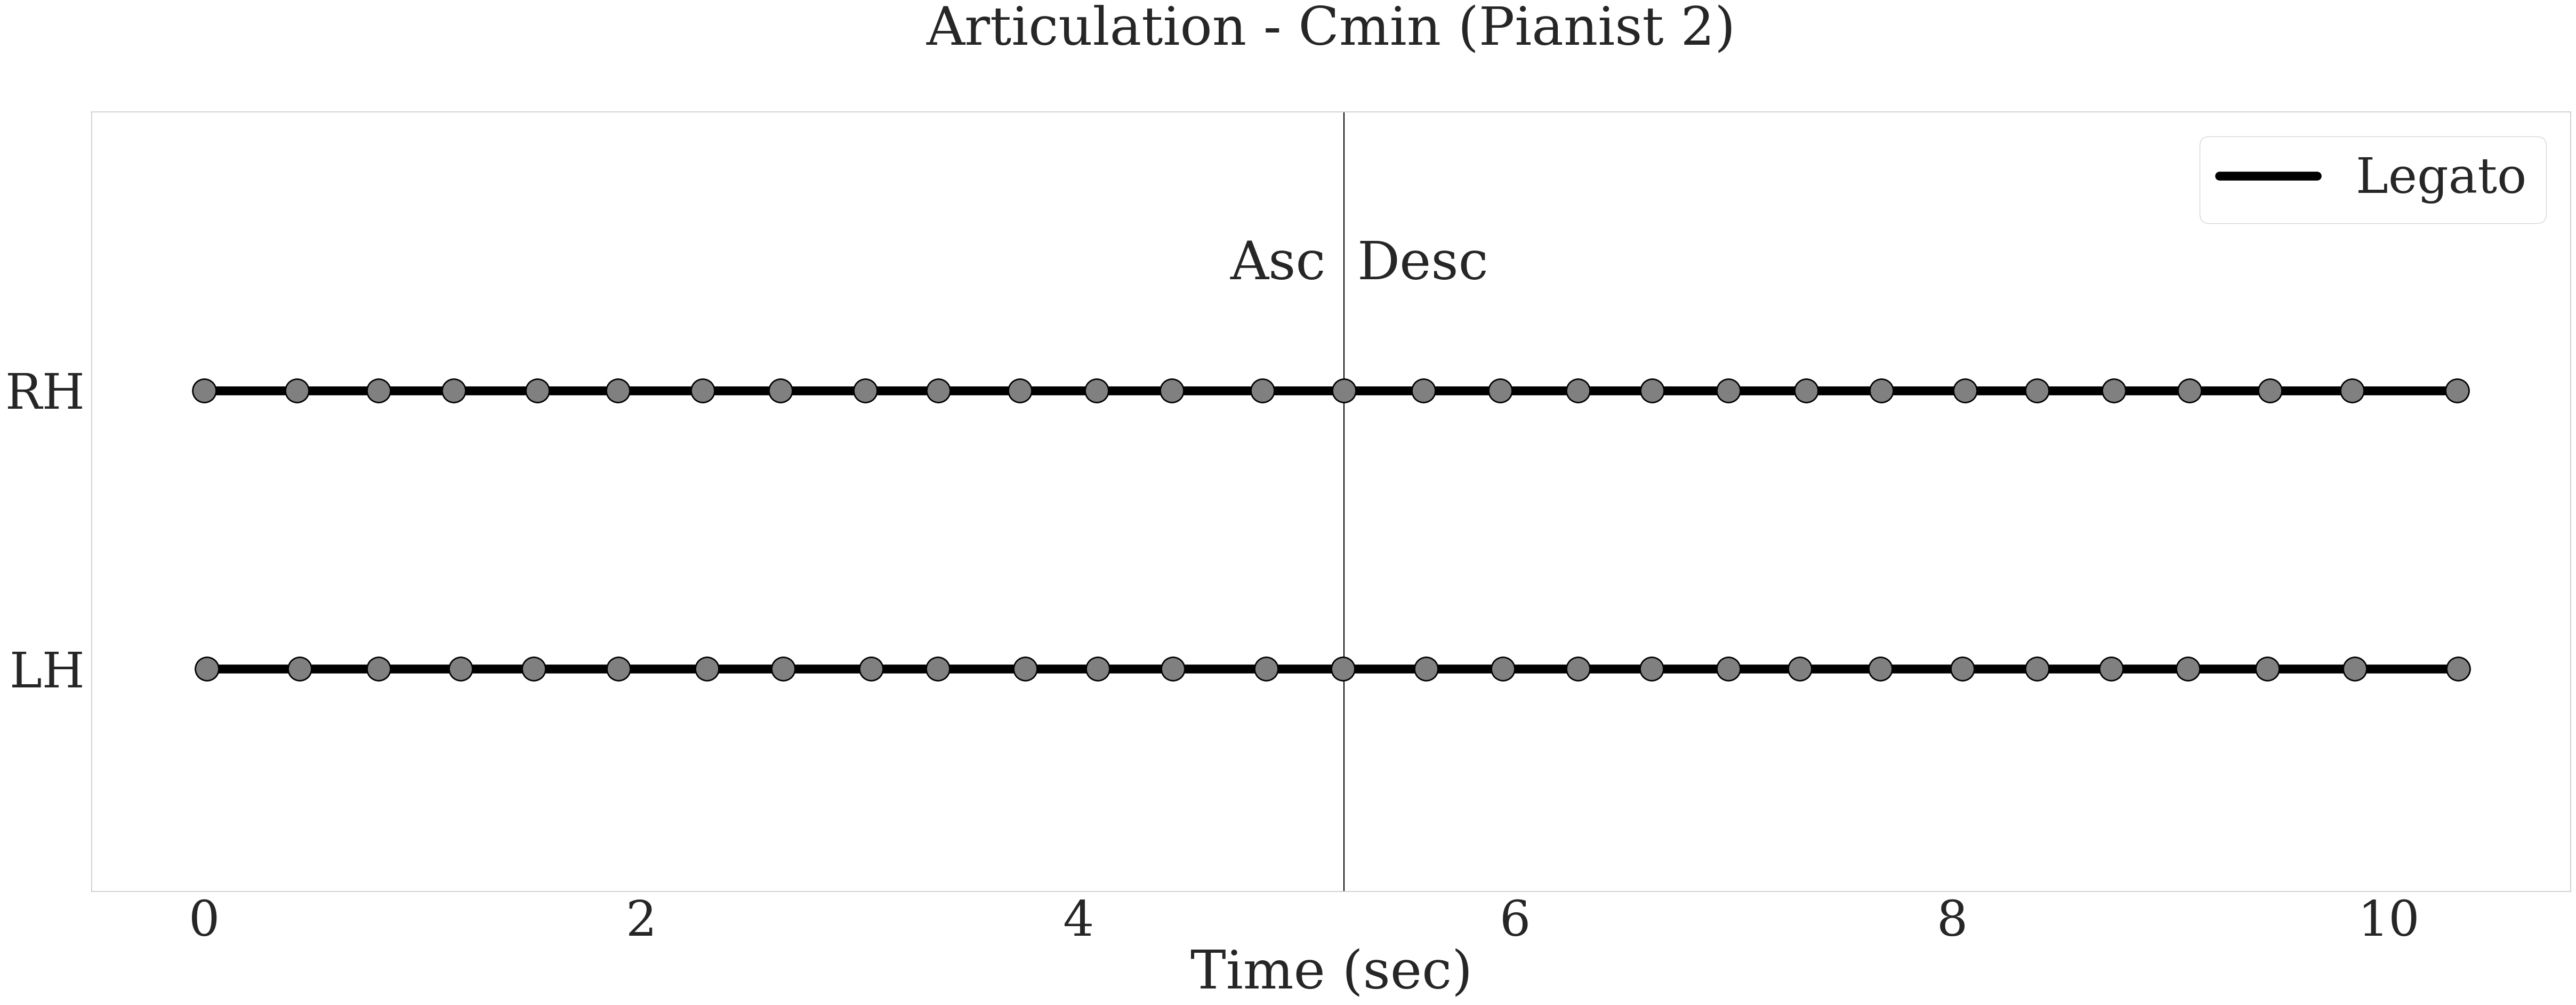

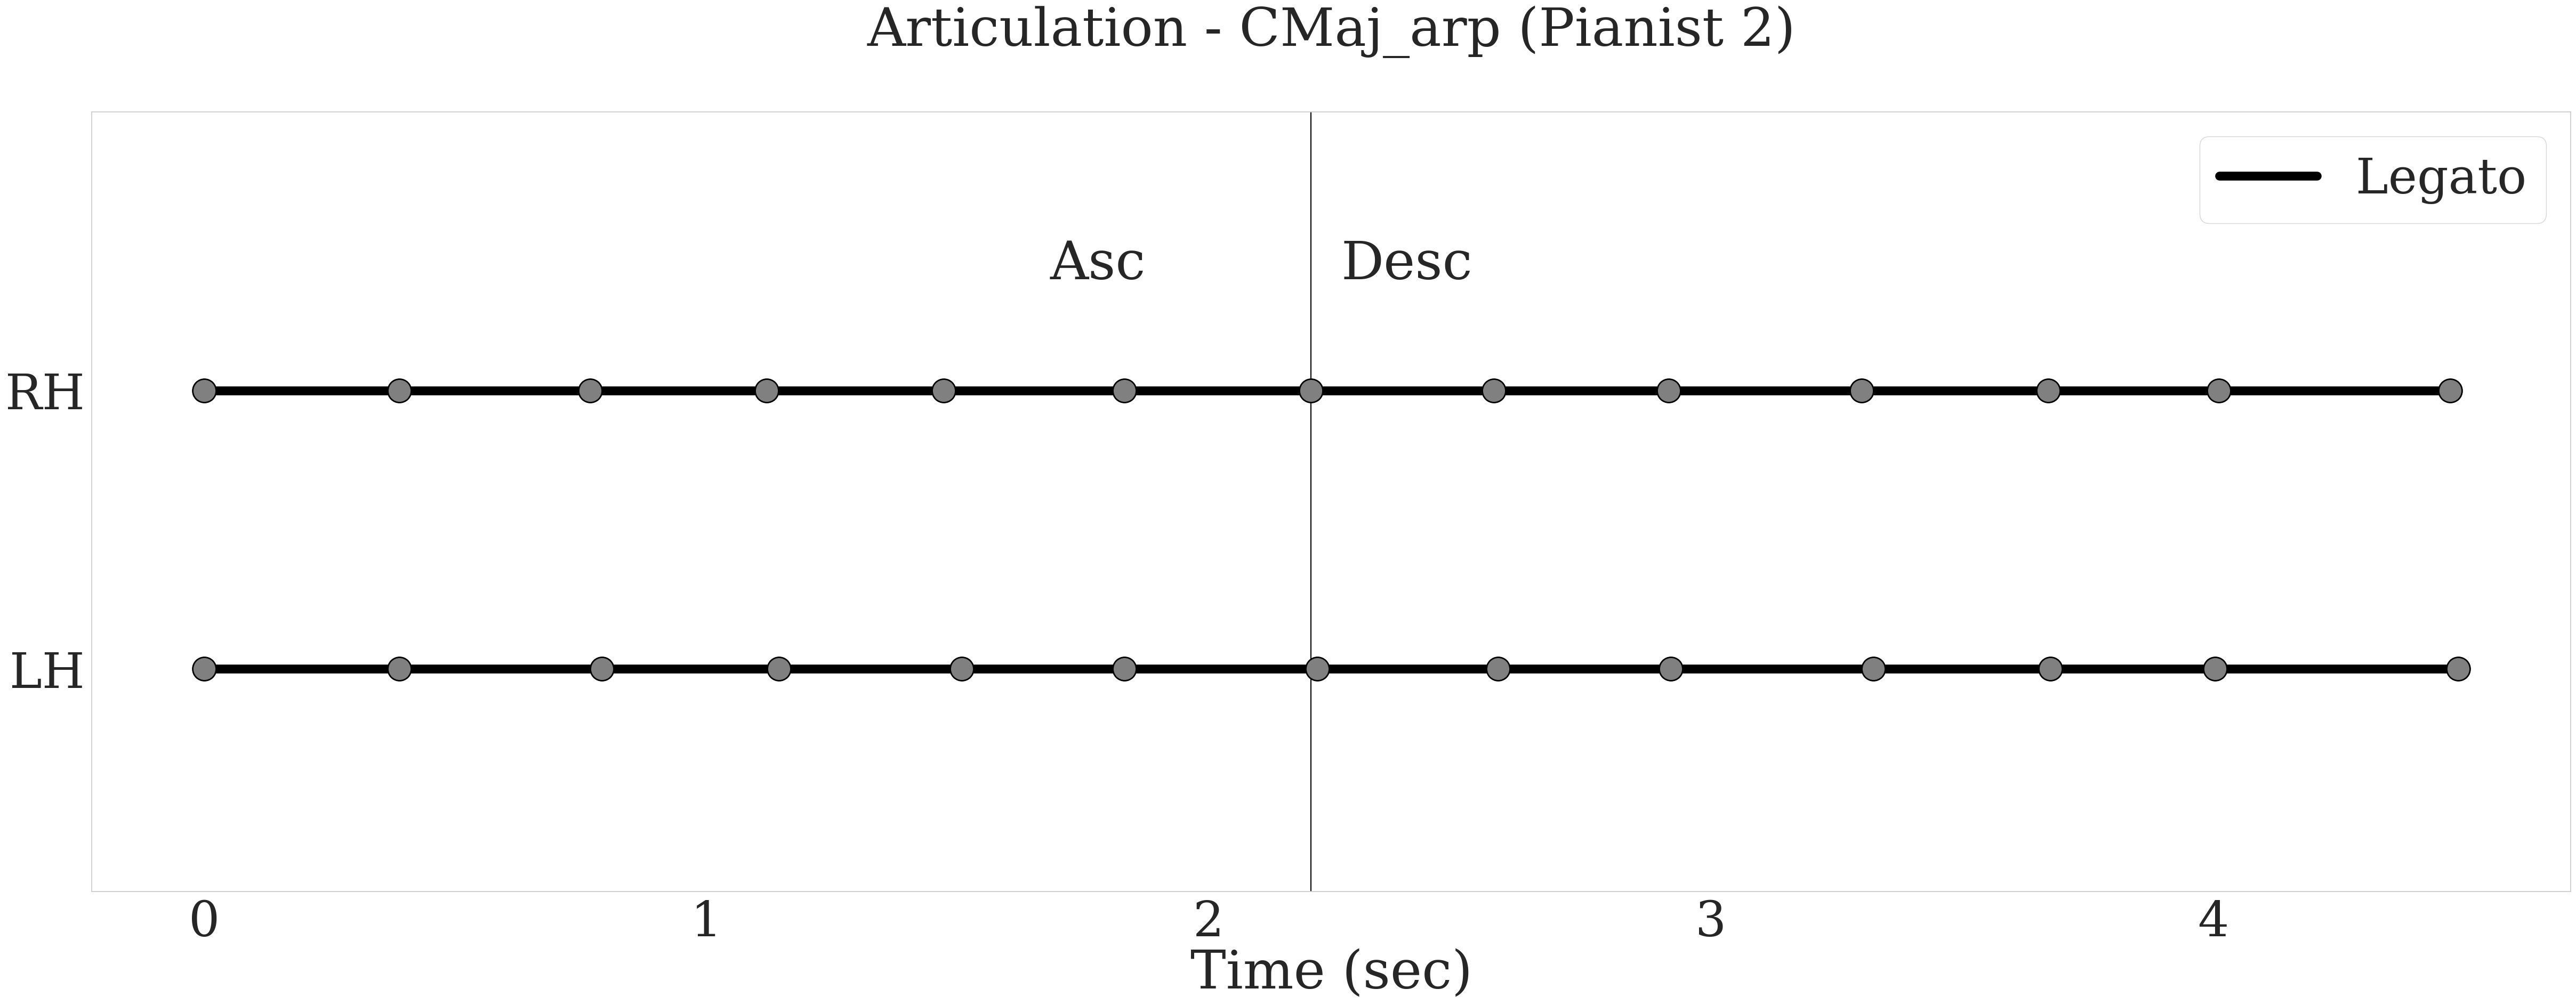

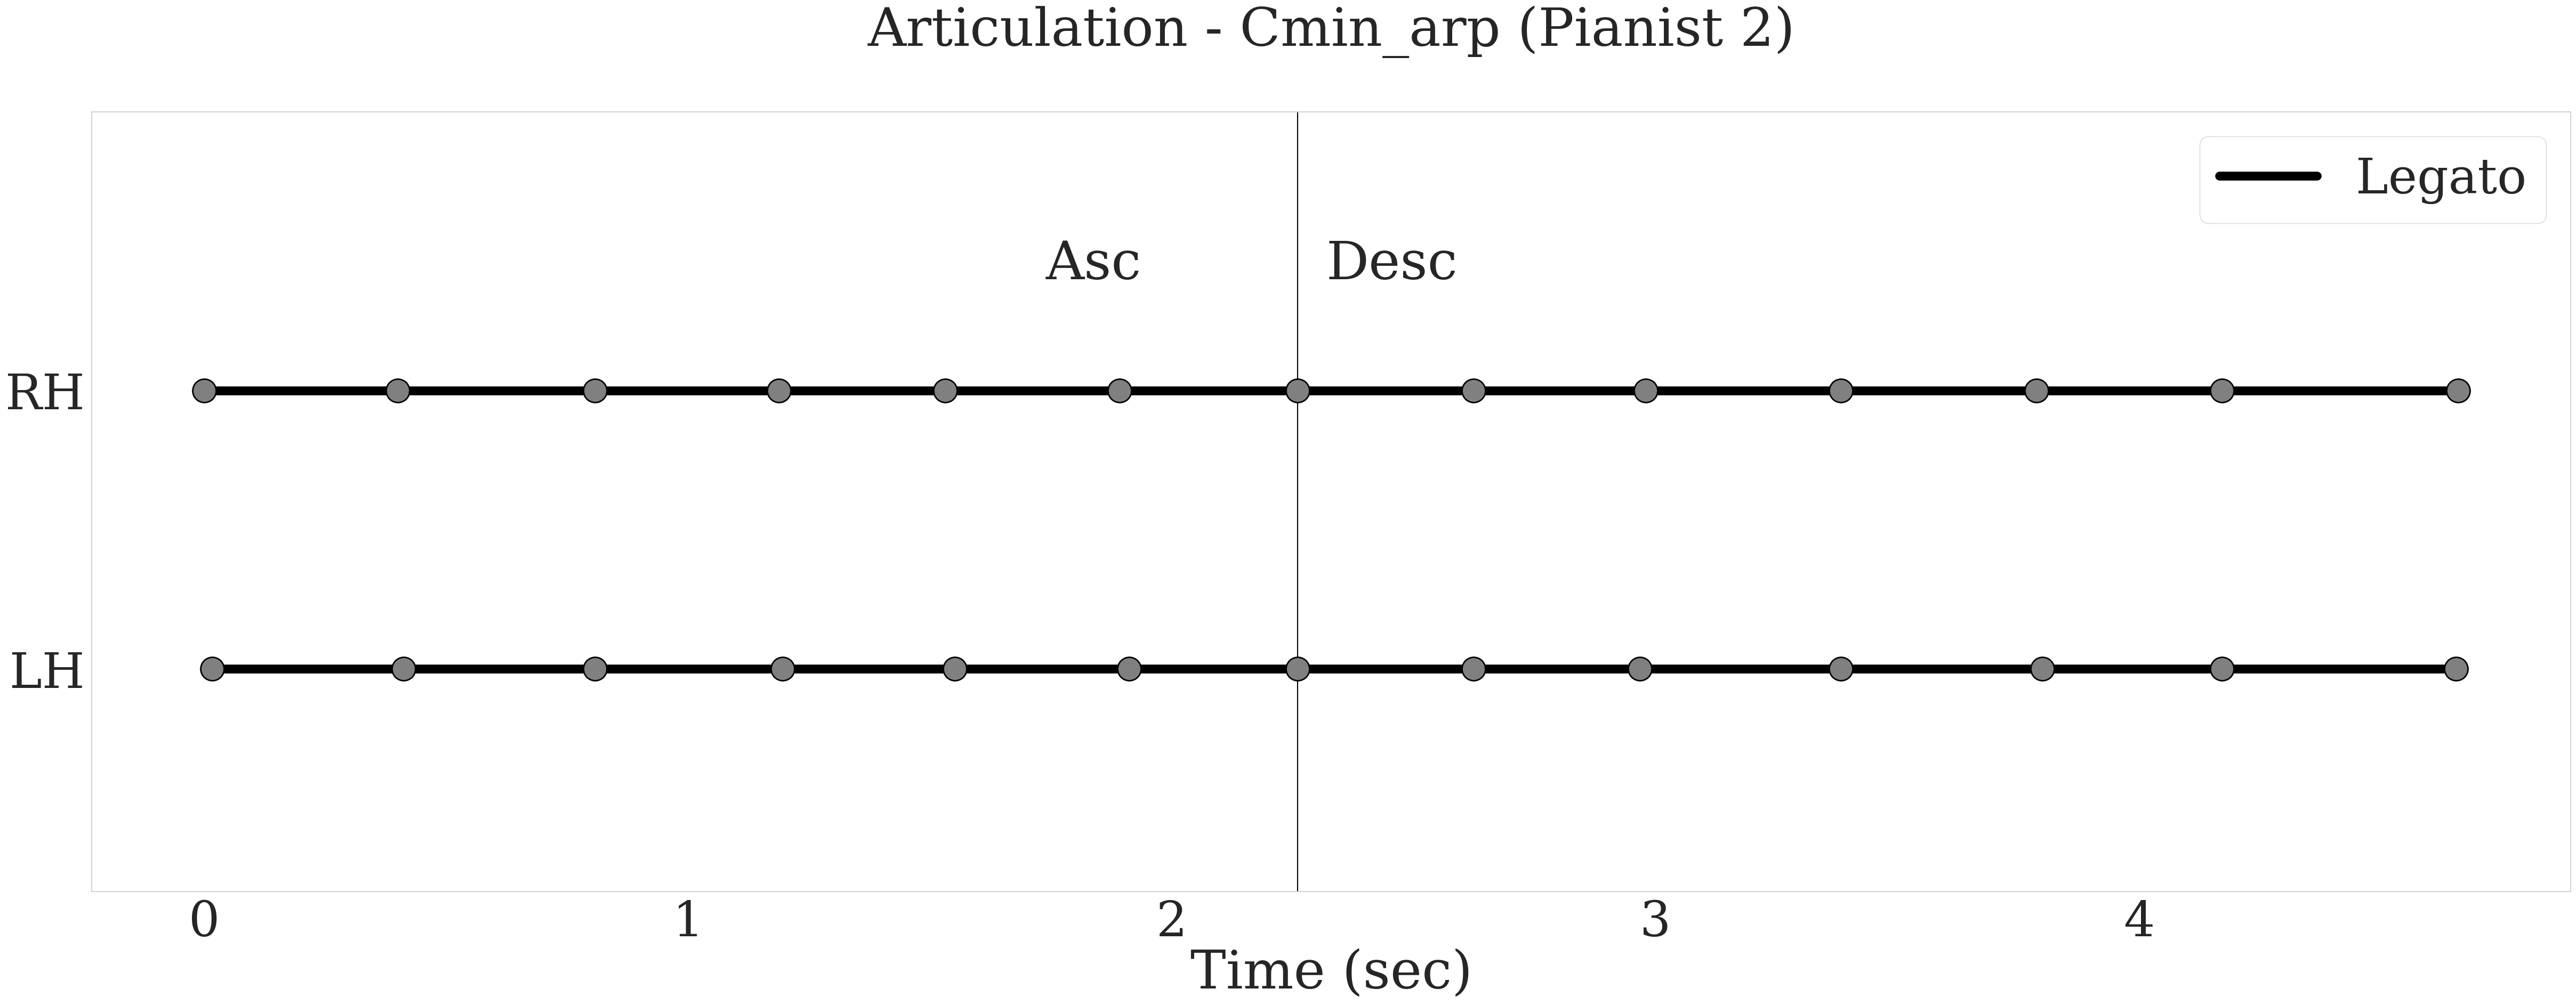

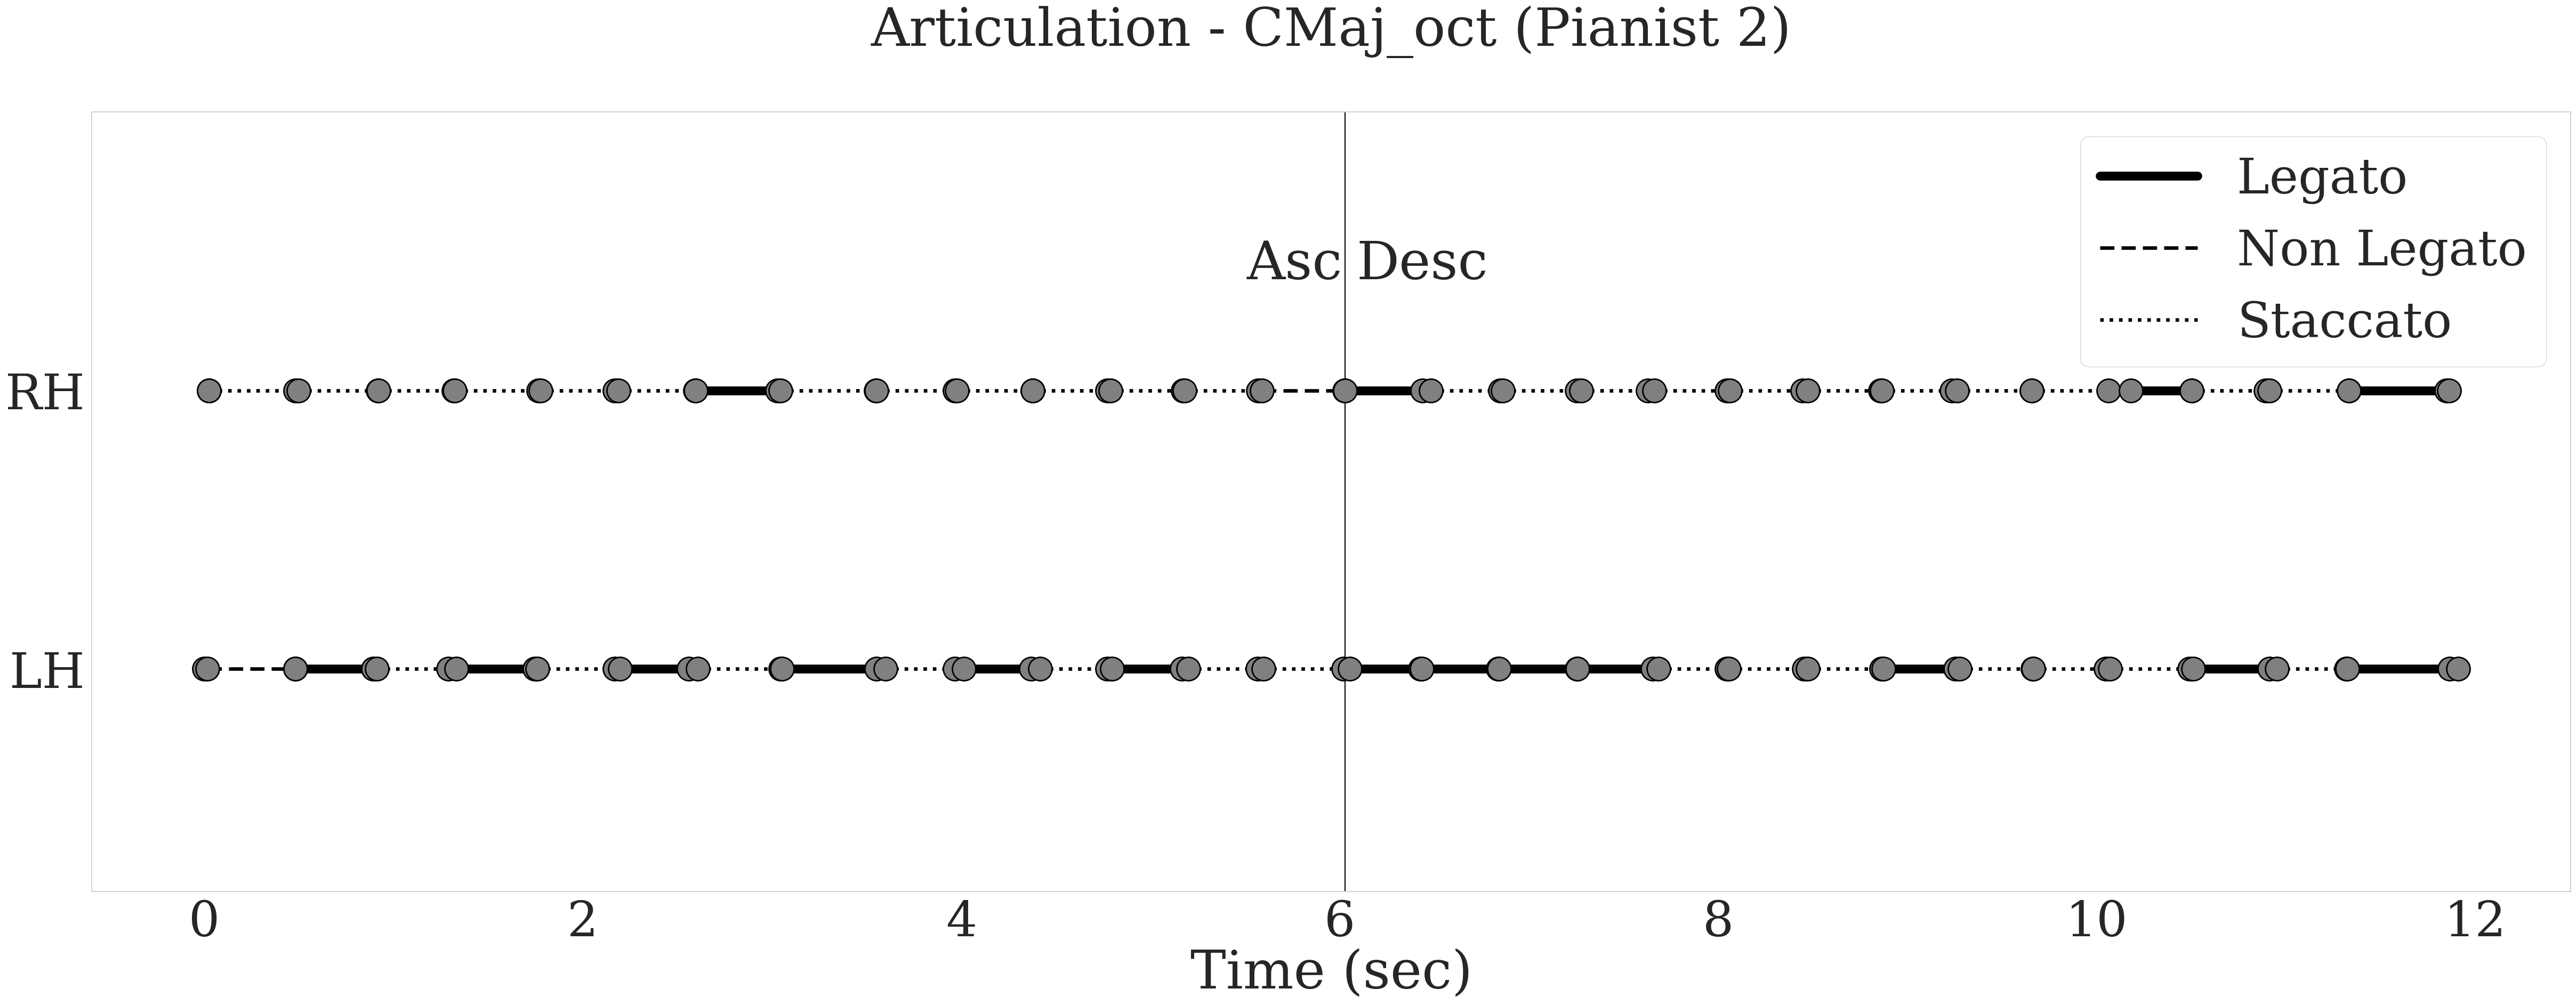

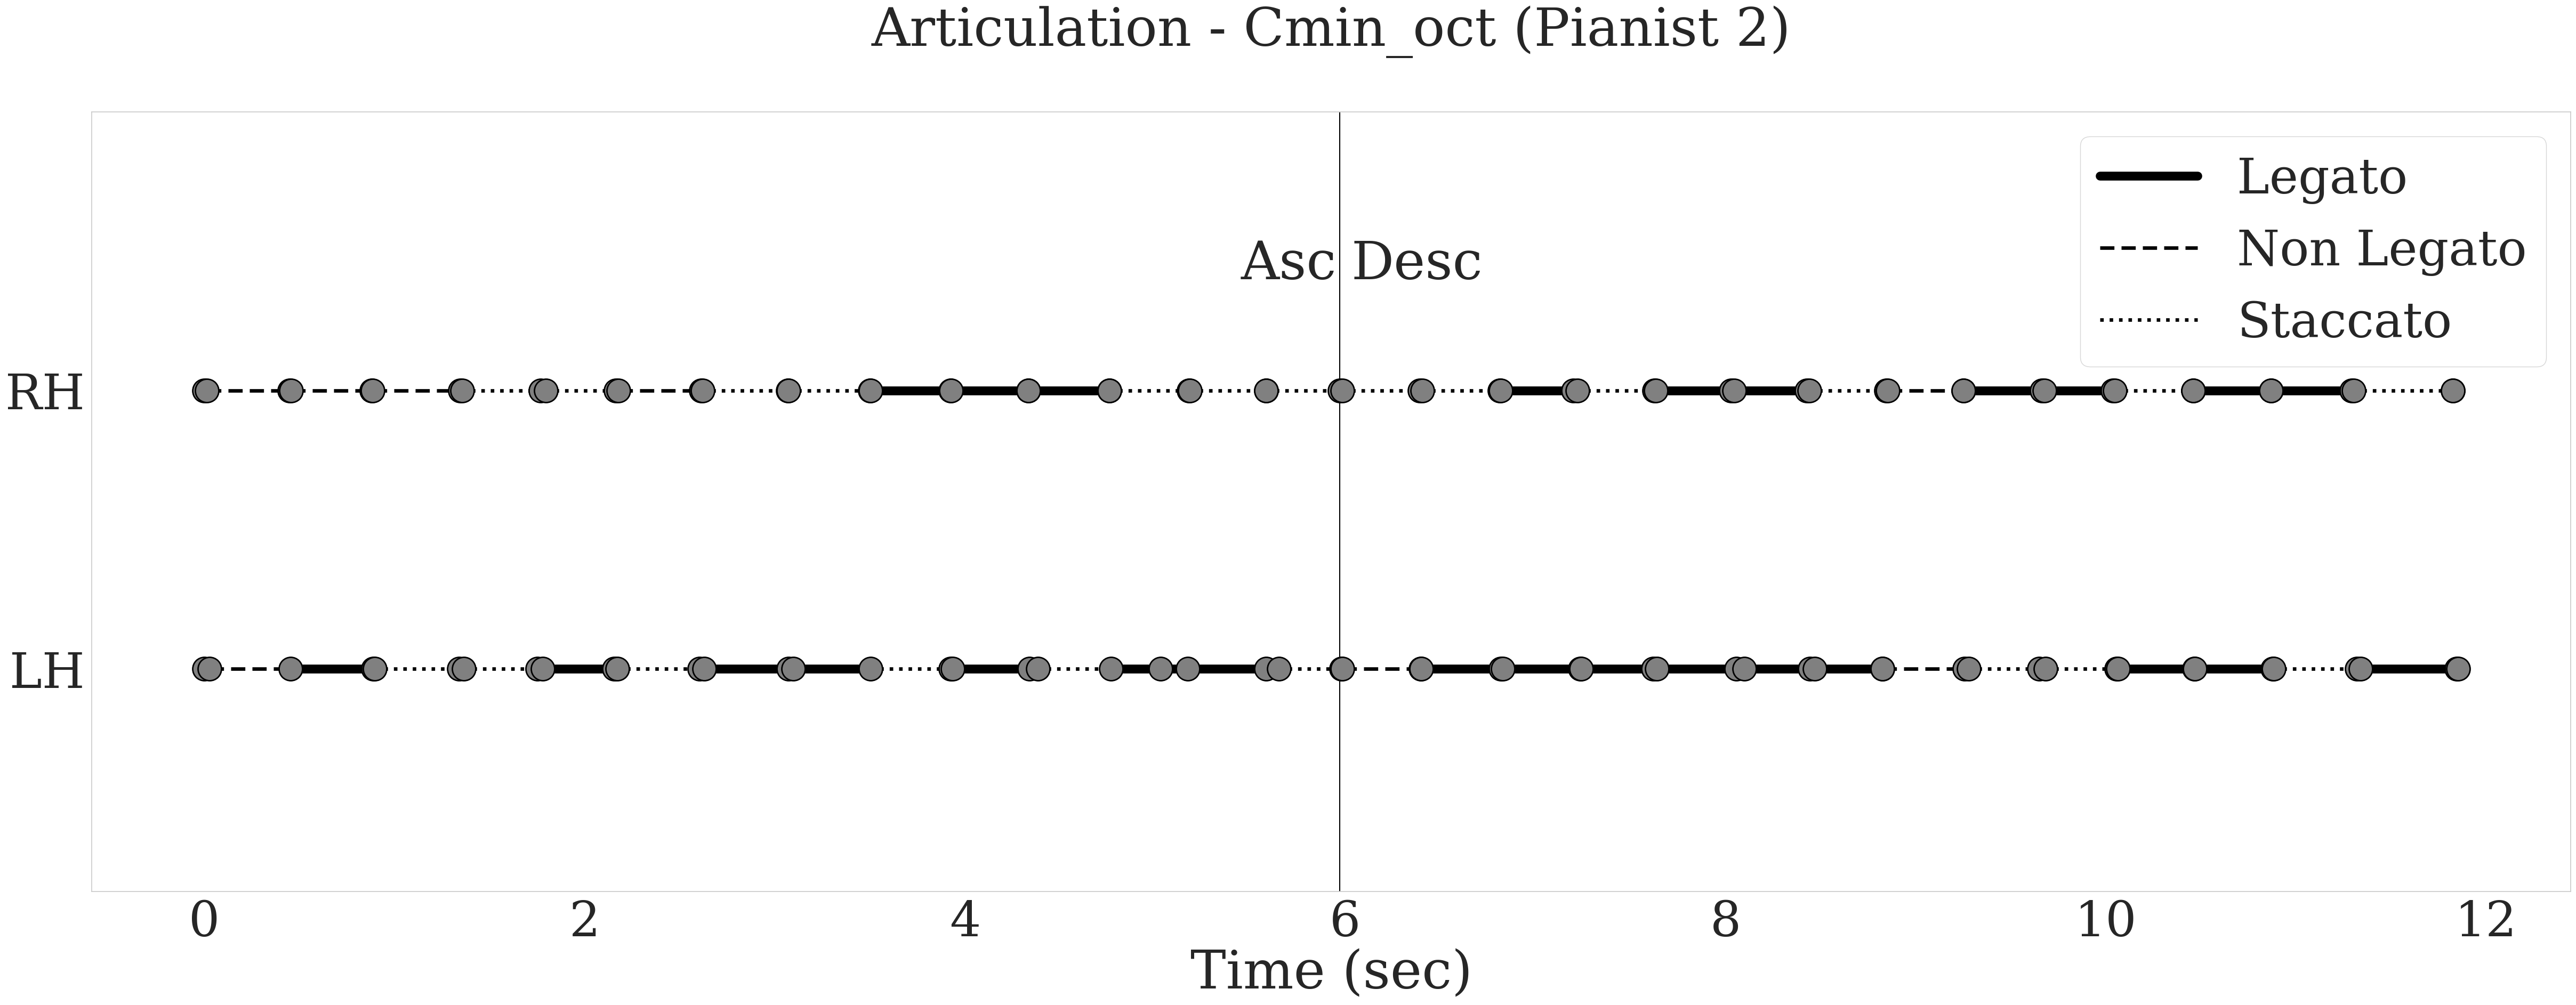

In [322]:
print_articulation_technical(df_articulation_technical, df_midi, 
                                 color_dict, linewidth_dict, linetype_dict)

#### Bach

In [293]:
# name = "02_Bach_BWV999_exp"
# motion_name = "02_Bach_BWV999_exp.csv"
# midi_name = "02_Bach_BWV999_exp_segm.csv"
# correctness_name = "02_Bach_BWV999_exp_segm_correctness.csv"

name = "02_Bach_BWV999_inexp"
motion_name = "02_Bach_BWV999_inexp.csv"
midi_name = "02_Bach_BWV999_inexp_segm.csv"
correctness_name = "02_Bach_BWV999_inexp_segm_correctness.csv"

df_motion = pd.read_csv("./Materials_/"+motion_name)
df_midi = pd.read_csv("./Materials_/"+midi_name)
df_correctness = pd.read_csv("../NoteCorrectness/"+correctness_name)
df_metadata = pd.read_csv("./Materials_/metadata_copy.csv")

In [294]:

framerate = 240
if df_motion.loc[1,"Time (ms)"]-df_motion.loc[0,"Time (ms)"] == 4:
    framerate = 250

In [240]:
bach_parts = {
    "Part 1 (m. 1-7)": (1,7), # first argument of tuple is measure, second is note
    "Part 2 (m. 7-12)": (7,13),
    "Part 4 (m. 13-16)": (13,16),
    "Part 1 (m. 16-20)": (16,20),
}

In [241]:
color_dict = {
    "Legato": "black",
    "Staccato": "black",
    "Non Legato": "black",
    "Pause": "violet",
}

linewidth_dict = {
    "Legato": 6,
    "Staccato": 4,
    "Non Legato": 4,
    "Pause": 5,
}

linetype_dict = {
    "Legato": '-',
    "Staccato": ':',
    "Non Legato": '--',
    "Pause": '-',    
}

hand_dict = {
    "LH": "LH",
    "RH": "RH"
}

In [242]:
def find_articulation_bach(df, name, 
                      legato_threshold_ms = 10,
                     staccato_threshold_ms = 20,
                     non_legato_threshold_ms = 30):
    
    df_articulation_stats = pd.DataFrame(columns = [
    "Name", "Hand", "Type", 'Start Time', 'End Time', 'Note Start', 'Note End'] 
    )
    
    df_init = df.copy(deep=True)
    
    legato_threshold_frames = int(legato_threshold_ms*1000/240)
    staccato_threshold_frames = int(staccato_threshold_ms*1000/240)
    non_legato_threshold_frames = int(non_legato_threshold_ms*1000/240)
    
    # both hands
    for hand in ["LH","RH"]:

        df = df_init[df_init["Hand"]==hand]
        df.reset_index(inplace=True, drop=True)
        rows = df.shape[0]
    
        seq = []
    
        for index, row in df.iterrows():
            if row['Measure']!= 0 and index < rows-1:

                start_curr = row['Start Midi']
                end_curr = row['End Midi']

                start_next = df.loc[index+1,'Start Midi']
                end_next = df.loc[index+1,'End Midi']

                if end_curr > start_next - legato_threshold_frames: 
                    df_articulation_stats = df_articulation_stats.append({
                            "Name": name,
                            "Hand": hand,
                            "Type": "Legato",
                            "Start Time": start_curr,
                            "End Time": start_next,
                            "Note Start" : row['Note'],
                            "Note End": df.loc[index+1,'Note']
                            }, ignore_index=True) 

                elif end_curr > start_next - staccato_threshold_frames:  
                    df_articulation_stats = df_articulation_stats.append({
                        "Name": name,
                        "Hand": hand,
                        "Type": "Staccato",
                        "Start Time": start_curr,
                        "End Time": start_next,
                        "Note Start" : row['Note'],
                        "Note End": df.loc[index+1,'Note']
                        }, ignore_index=True)     

                elif end_curr > start_next - non_legato_threshold_frames:  
                    df_articulation_stats = df_articulation_stats.append({
                        "Name": name,
                        "Hand": hand,
                        "Type": "Non Legato",
                        "Start Time": start_curr,
                        "End Time": start_next,
                        "Note Start" : row['Note'],
                        "Note End": df.loc[index+1,'Note']
                        }, ignore_index=True) 
                else:
                    df_articulation_stats = df_articulation_stats.append({
                        "Name": name,
                        "Hand": hand,
                        "Type": "Pause",
                        "Start Time": start_curr,
                        "End Time": start_next,
                        "Note Start" : row['Note'],
                        "Note End": df.loc[index+1,'Note']
                        }, ignore_index=True) 

    # total hand
    df = df_init.copy(True)
    df.reset_index(inplace=True, drop=True)
    rows = df.shape[0]

    for index, row in df.iterrows():
        if row['Measure']!= 0 and index < rows-1:

            start_curr = row['Start Midi']
            end_curr = row['End Midi']

            start_next = df.loc[index+1,'Start Midi']
            end_next = df.loc[index+1,'End Midi']

            if end_curr > start_next - legato_threshold_frames: 
                df_articulation_stats = df_articulation_stats.append({
                        "Name": name,
                        "Hand": "Both",
                        "Type": "Legato",
                        "Start Time": start_curr,
                        "End Time": start_next,
                        "Note Start" : row['Note'],
                        "Note End": df.loc[index+1,'Note']
                        }, ignore_index=True) 

            elif end_curr > start_next - staccato_threshold_frames:  
                df_articulation_stats = df_articulation_stats.append({
                    "Name": name,
                    "Hand": "Both",
                    "Type": "Staccato",
                    "Start Time": start_curr,
                    "End Time": start_next,
                    "Note Start" : row['Note'],
                    "Note End": df.loc[index+1,'Note']
                    }, ignore_index=True)     

            elif end_curr > start_next - non_legato_threshold_frames:  
                df_articulation_stats = df_articulation_stats.append({
                    "Name": name,
                    "Hand": "Both",
                    "Type": "Non Legato",
                    "Start Time": start_curr,
                    "End Time": start_next,
                    "Note Start" : row['Note'],
                    "Note End": df.loc[index+1,'Note']
                    }, ignore_index=True) 
            else:
                df_articulation_stats = df_articulation_stats.append({
                    "Name": name,
                    "Hand": "Both",
                    "Type": "Pause",
                    "Start Time": start_curr,
                    "End Time": start_next,
                    "Note Start" : row['Note'],
                    "Note End": df.loc[index+1,'Note']
                    }, ignore_index=True)               
    df_articulation_stats.to_csv(("./statistics/"+name+"_legato_threshold"+str(legato_threshold_ms)+
                            "_staccato_threshold"+str(staccato_threshold_ms)+"_non_legato_threshold"+
                            str(non_legato_threshold_ms)+"_articulation_stats.csv")) 
    
    
    return df_articulation_stats

In [243]:
def find_hand(df_art_, start_time):
    
    for index, row in df_art_.iterrows():
        if start_time == row['Start Time']:
            return row['Hand']
    return None

In [244]:
def print_articulation_bach(df_art, df_mid, 
                                 color_dict, linewidth_dict, 
                                 linetype_dict):
    

    sns.set(rc={'figure.figsize':(60,19)},font_scale=6)
    sns.set_style("whitegrid", {'font.family':'serif', 'font.serif':'Times New Roman'})
    
    df_art_rh = df_art[df_art["Hand"]=="RH"] 
    df_art_lh = df_art[df_art["Hand"]=="LH"] 
    
    df_mid_rh = df_mid[df_mid["Hand"]=="RH"] 
    df_mid_lh = df_mid[df_mid["Hand"]=="LH"]     
    
    for key, value in bach_parts.items():    
    
        fig, ax = plt.subplots()
        plt.rcParams.update()    
    
        start_measure = value[0]
        end_measure = value[1]

    
        # right hand
        df_mid_rh_part = df_mid_rh[df_mid_rh['Measure']>=start_measure]
        df_mid_rh_part = df_mid_rh_part[df_mid_rh_part['Measure']<=end_measure]
        df_mid_rh_part.reset_index(inplace=True, drop=True)
        number_of_notes_at_last_measure = df_mid_rh_part[df_mid_rh_part["Measure"]==end_measure].shape[0]
        df_mid_rh_part.loc[df_mid_rh_part.shape[0] - number_of_notes_at_last_measure,:]
        
        start_rh = min(df_mid_rh_part['Start Midi'])
        end_rh = max(df_mid_rh_part['Start Midi'])
        
        df_art_rh_part = df_art_rh[df_art_rh['Start Time']>=start_rh]
        df_art_rh_part = df_art_rh_part[df_art_rh_part['End Time']<=end_rh]
        
        # left hand
        df_mid_lh_part = df_mid_lh[df_mid_lh['Measure']>=start_measure]
        df_mid_lh_part = df_mid_lh_part[df_mid_lh_part['Measure']<=end_measure]
        df_mid_lh_part.reset_index(inplace=True, drop=True)
        number_of_notes_at_last_measure = df_mid_lh_part[df_mid_lh_part["Measure"]==end_measure].shape[0]
        df_mid_lh_part.loc[df_mid_lh_part.shape[0] - number_of_notes_at_last_measure,:]
        
        start_lh = min(df_mid_lh_part['Start Midi'])
        end_lh = max(df_mid_lh_part['Start Midi'])
        
        df_art_lh_part = df_art_lh[df_art_lh['Start Time']>=start_lh]
        df_art_lh_part = df_art_lh_part[df_art_lh_part['End Time']<=end_lh]

        
        remove = []
        for index, row in df_art_lh_part.iterrows():
        
            start = int(row["Start Time"])
            end = int(row["End Time"])

            x = [i/framerate for i in range(start,end+1)]
            y = ["LH" for _ in range(start,end+1)]
            
            if row["Type"] == "Pause":
                remove.append(end)
            else:
                plt.plot(x, y, linetype_dict[row["Type"]], label = row["Type"],
                           color = color_dict[row["Type"]], linewidth=2*linewidth_dict[row["Type"]],zorder=5)
    
        for index, row in df_mid_lh_part.iterrows():
            if row['Start Midi'] not in remove:
                plt.scatter(row['Start Midi']/framerate, "LH", edgecolors='black',linewidth=2,
                            color="gray",
                            s=1000, zorder=10)    
        
        remove = []
        for index, row in df_art_rh_part.iterrows():
        
            start = int(row["Start Time"])
            end = int(row["End Time"])

            x = [i/framerate for i in range(start,end+1)]
            y = ["RH" for _ in range(start,end+1)]
            
            if row["Type"] == "Pause":
                remove.append(end)
            else:
                plt.plot(x, y, linetype_dict[row["Type"]], label = row["Type"],
                           color = color_dict[row["Type"]], linewidth=2*linewidth_dict[row["Type"]],zorder=5)
    
        for index, row in df_mid_rh_part.iterrows():
            if row['Start Midi'] not in remove:
                plt.scatter(row['Start Midi']/framerate, "RH", edgecolors='black',linewidth=2,
                            color="gray",
                            s=1000,zorder=10)
        
        # plot lines total
        df_art_both = df_art[df_art["Hand"] == "Both"]
        
        remove = []
        for index, row in df_art_both.iterrows():
        
            start = int(row["Start Time"])
            end = int(row["End Time"])
            
#             print(start,end)
            
#             print(df_art_rh_part,df_art_lh_part)
            
            start_hand = find_hand(df_art_rh_part, start)
            if start_hand == None:
                start_hand = find_hand(df_art_lh_part, start)
                
            end_hand = find_hand(df_art_rh_part, end)
            if end_hand == None:
                end_hand = find_hand(df_art_lh_part, end)

            if start_hand == None or end_hand == None:
                continue
                
            if start_hand!=end_hand:
            
                x = [start/framerate,end/framerate]
                y = [hand_dict[start_hand], hand_dict[end_hand]]

                
                
                if row["Type"] == "Pause":
                    remove.append(end)
                else:
                    plt.plot(x, y, linetype_dict[row["Type"]], label = row["Type"],
                               color = color_dict[row["Type"]], linewidth=2*linewidth_dict[row["Type"]],zorder=5)
        
    
        plt.title("Articulation Bach - "+ key +" (Pianist " + name[1] + ")", y =1.08)
        plt.xlabel('Time (Sec)')

        plt.ylim(-0.8,2)
        ax.yaxis.grid(False) # Hide the horizontal gridlines
        ax.xaxis.grid(False) # Show the vertical gridlines
        ax.set_yticks(["RH", "LH"])
        ax.legend()

        legend_without_duplicate_labels(ax)

        plt.savefig("./plots/articulation/articulation_"+ name+ "_"+key+".png")
        plt.show()
        plt.close()    
    
    

In [245]:
if "Bach" in name:
    df_articulation_bach = find_articulation_bach(df_midi, name, 
                      legato_threshold_ms = 10,
                     staccato_threshold_ms = 20,
                     non_legato_threshold_ms = 50)

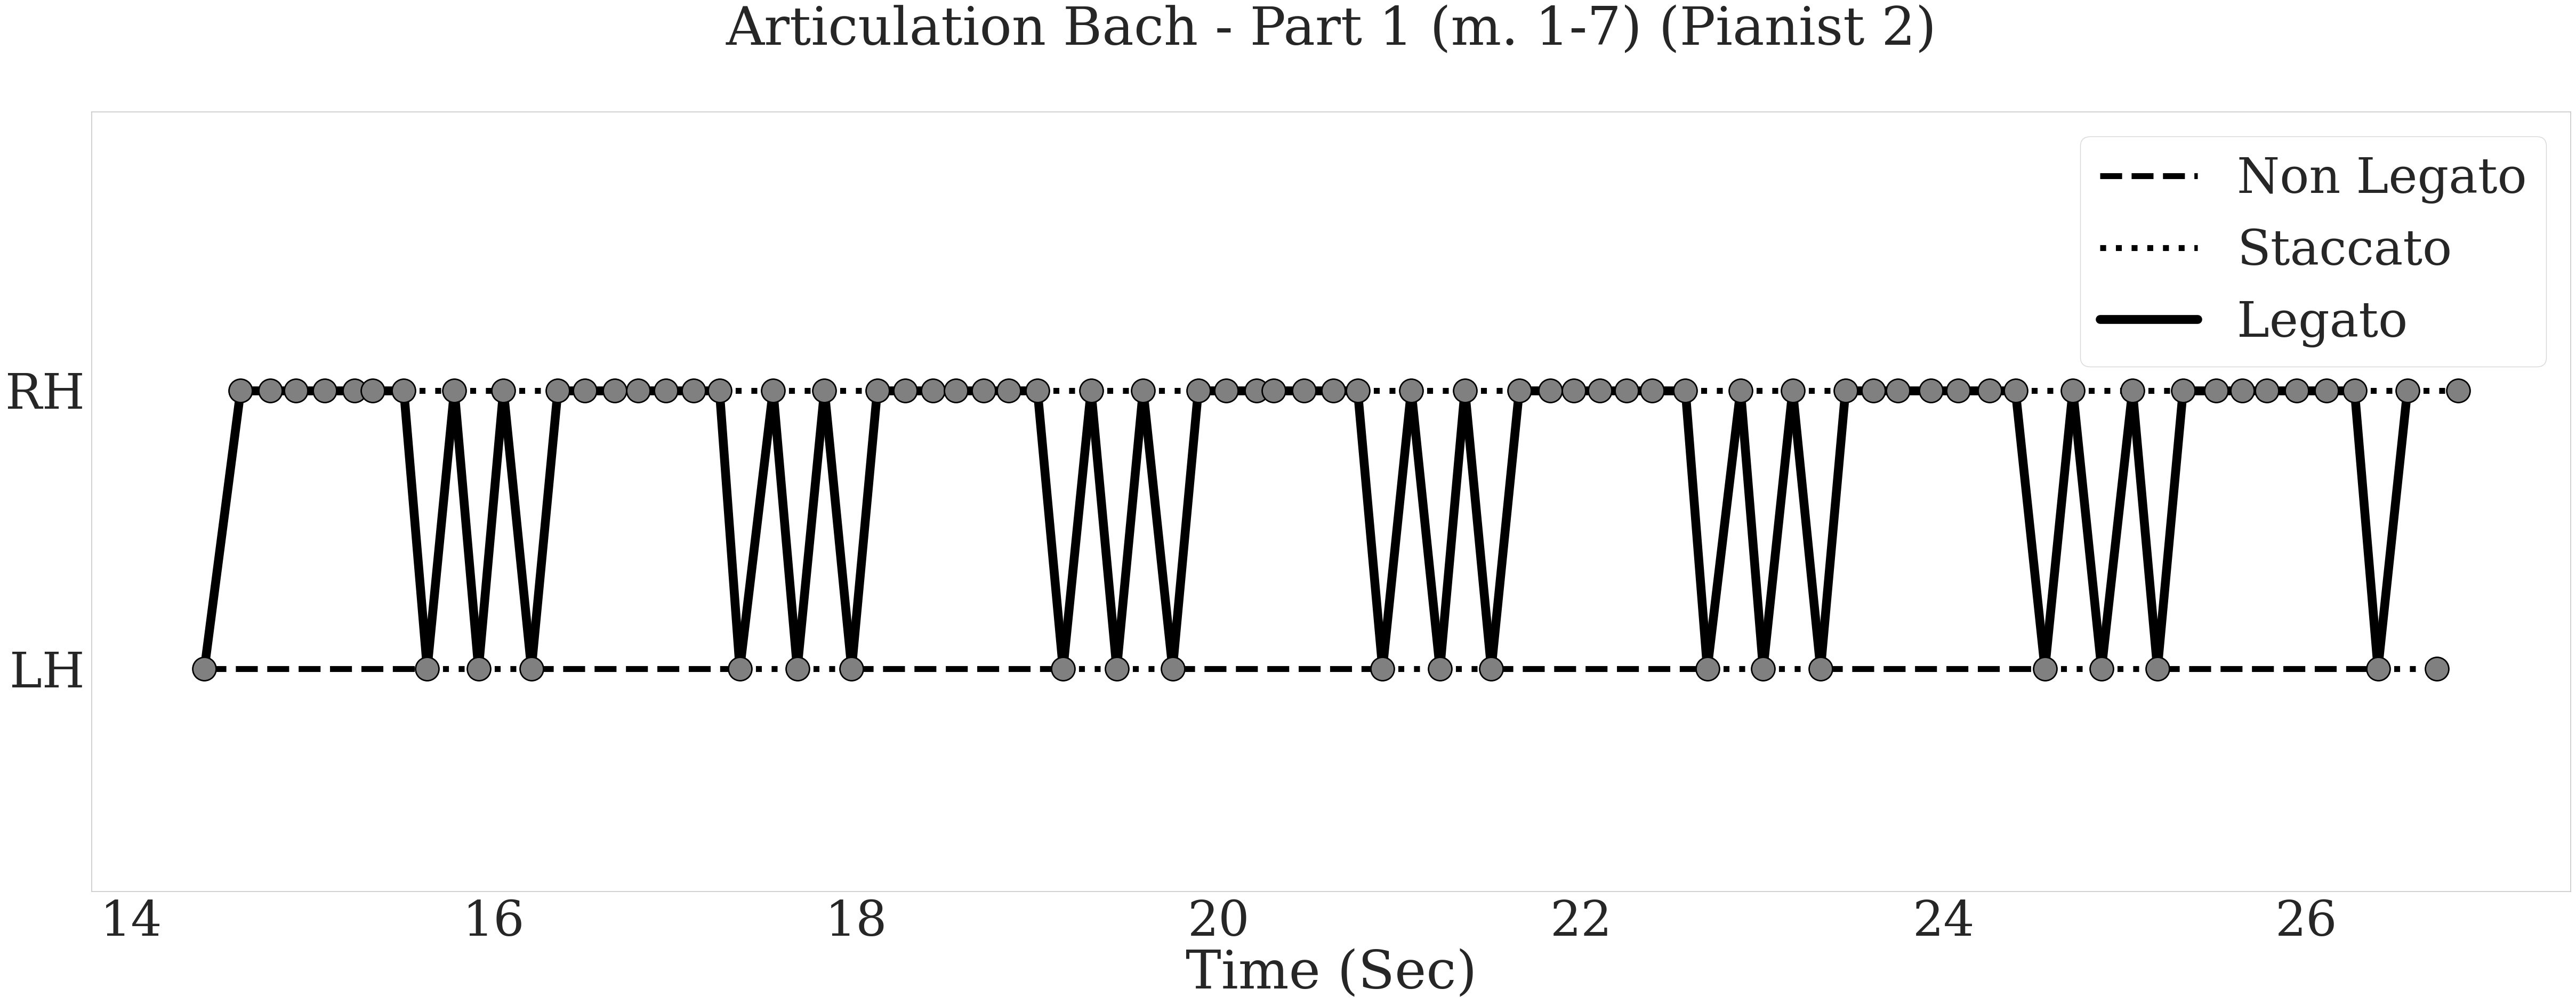

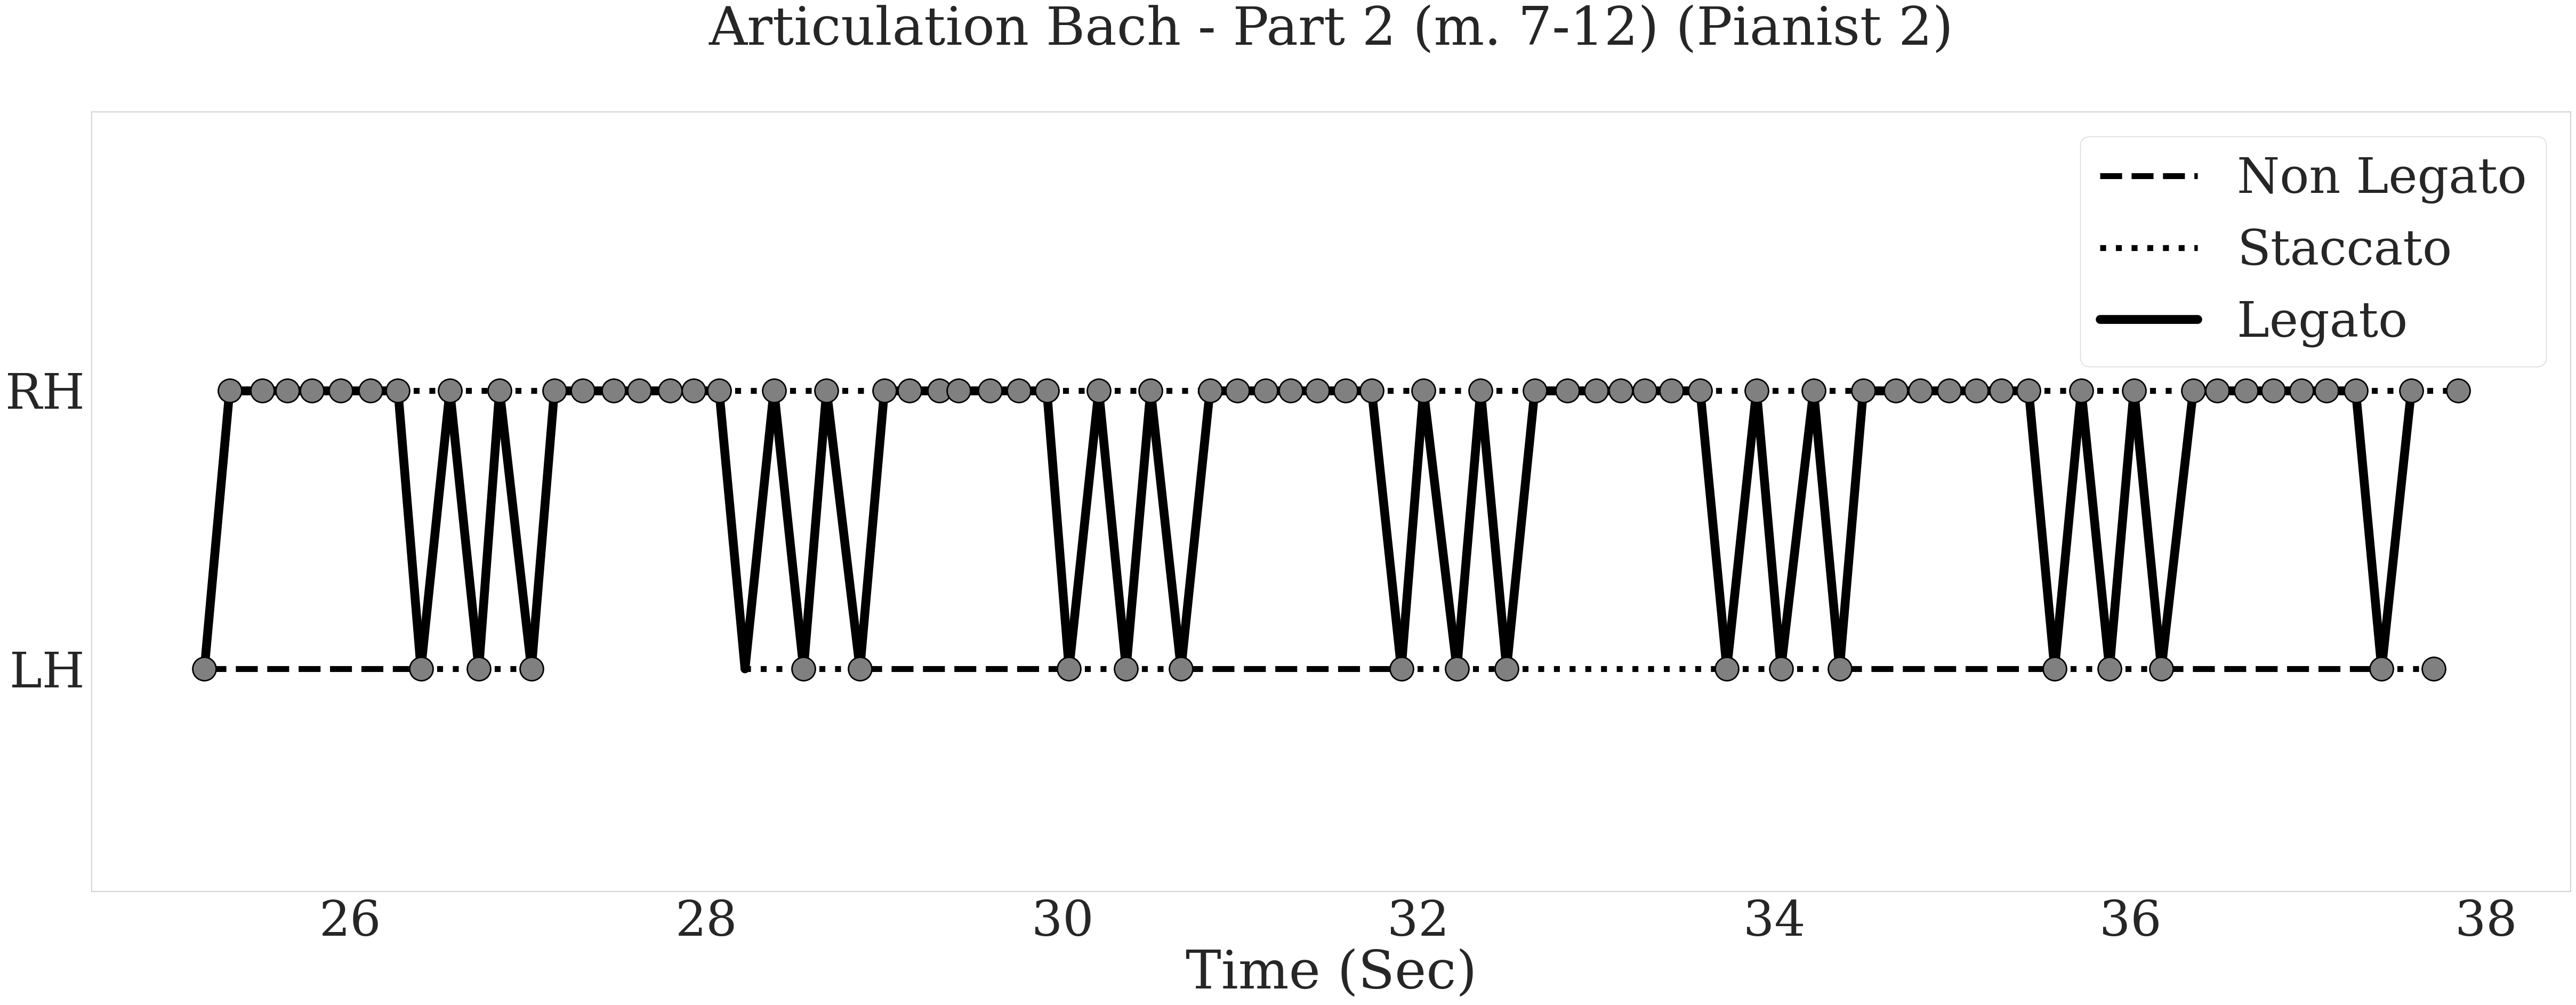

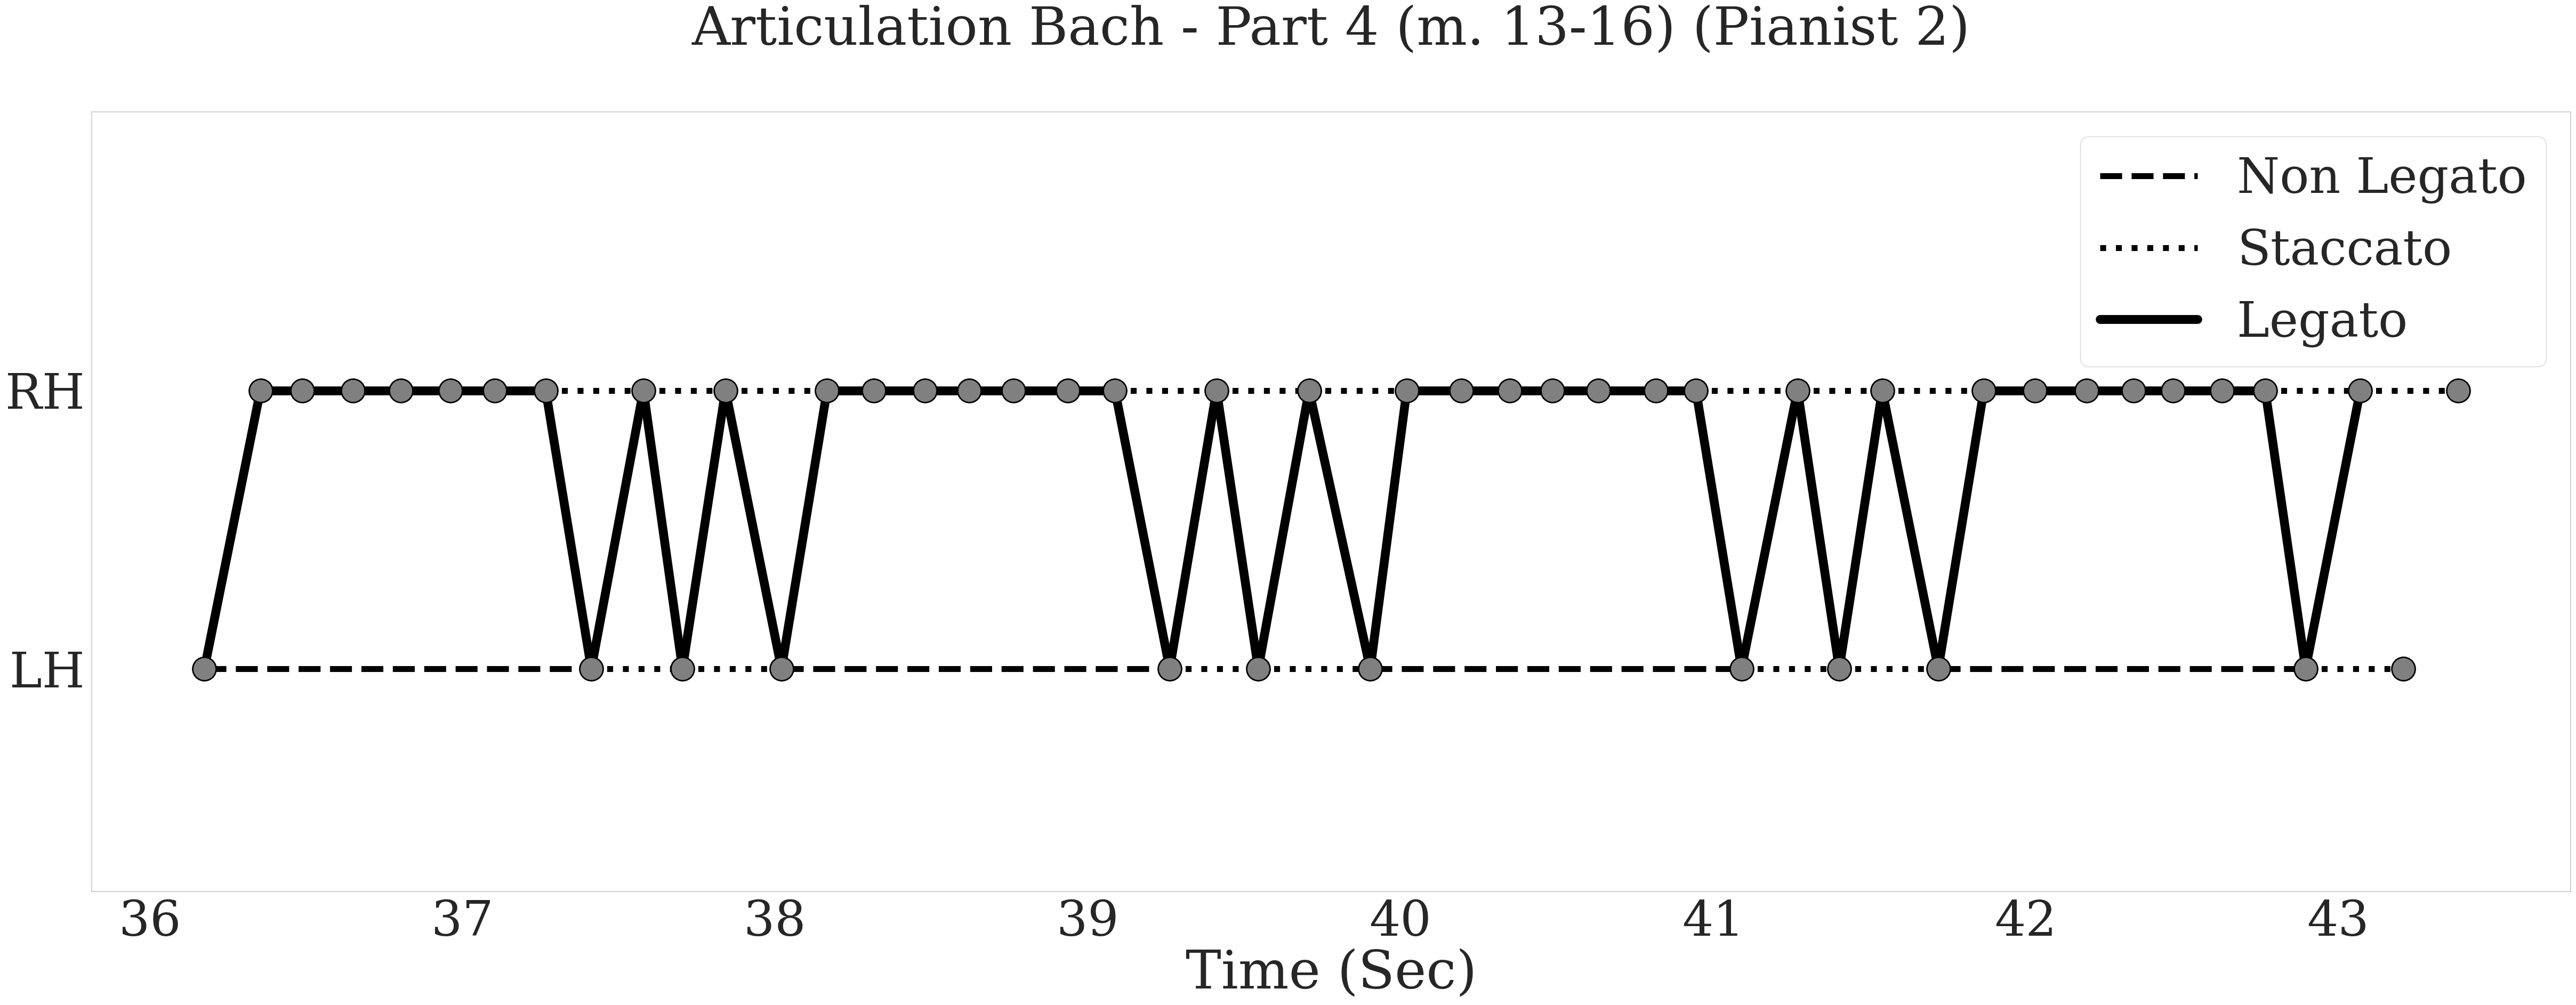

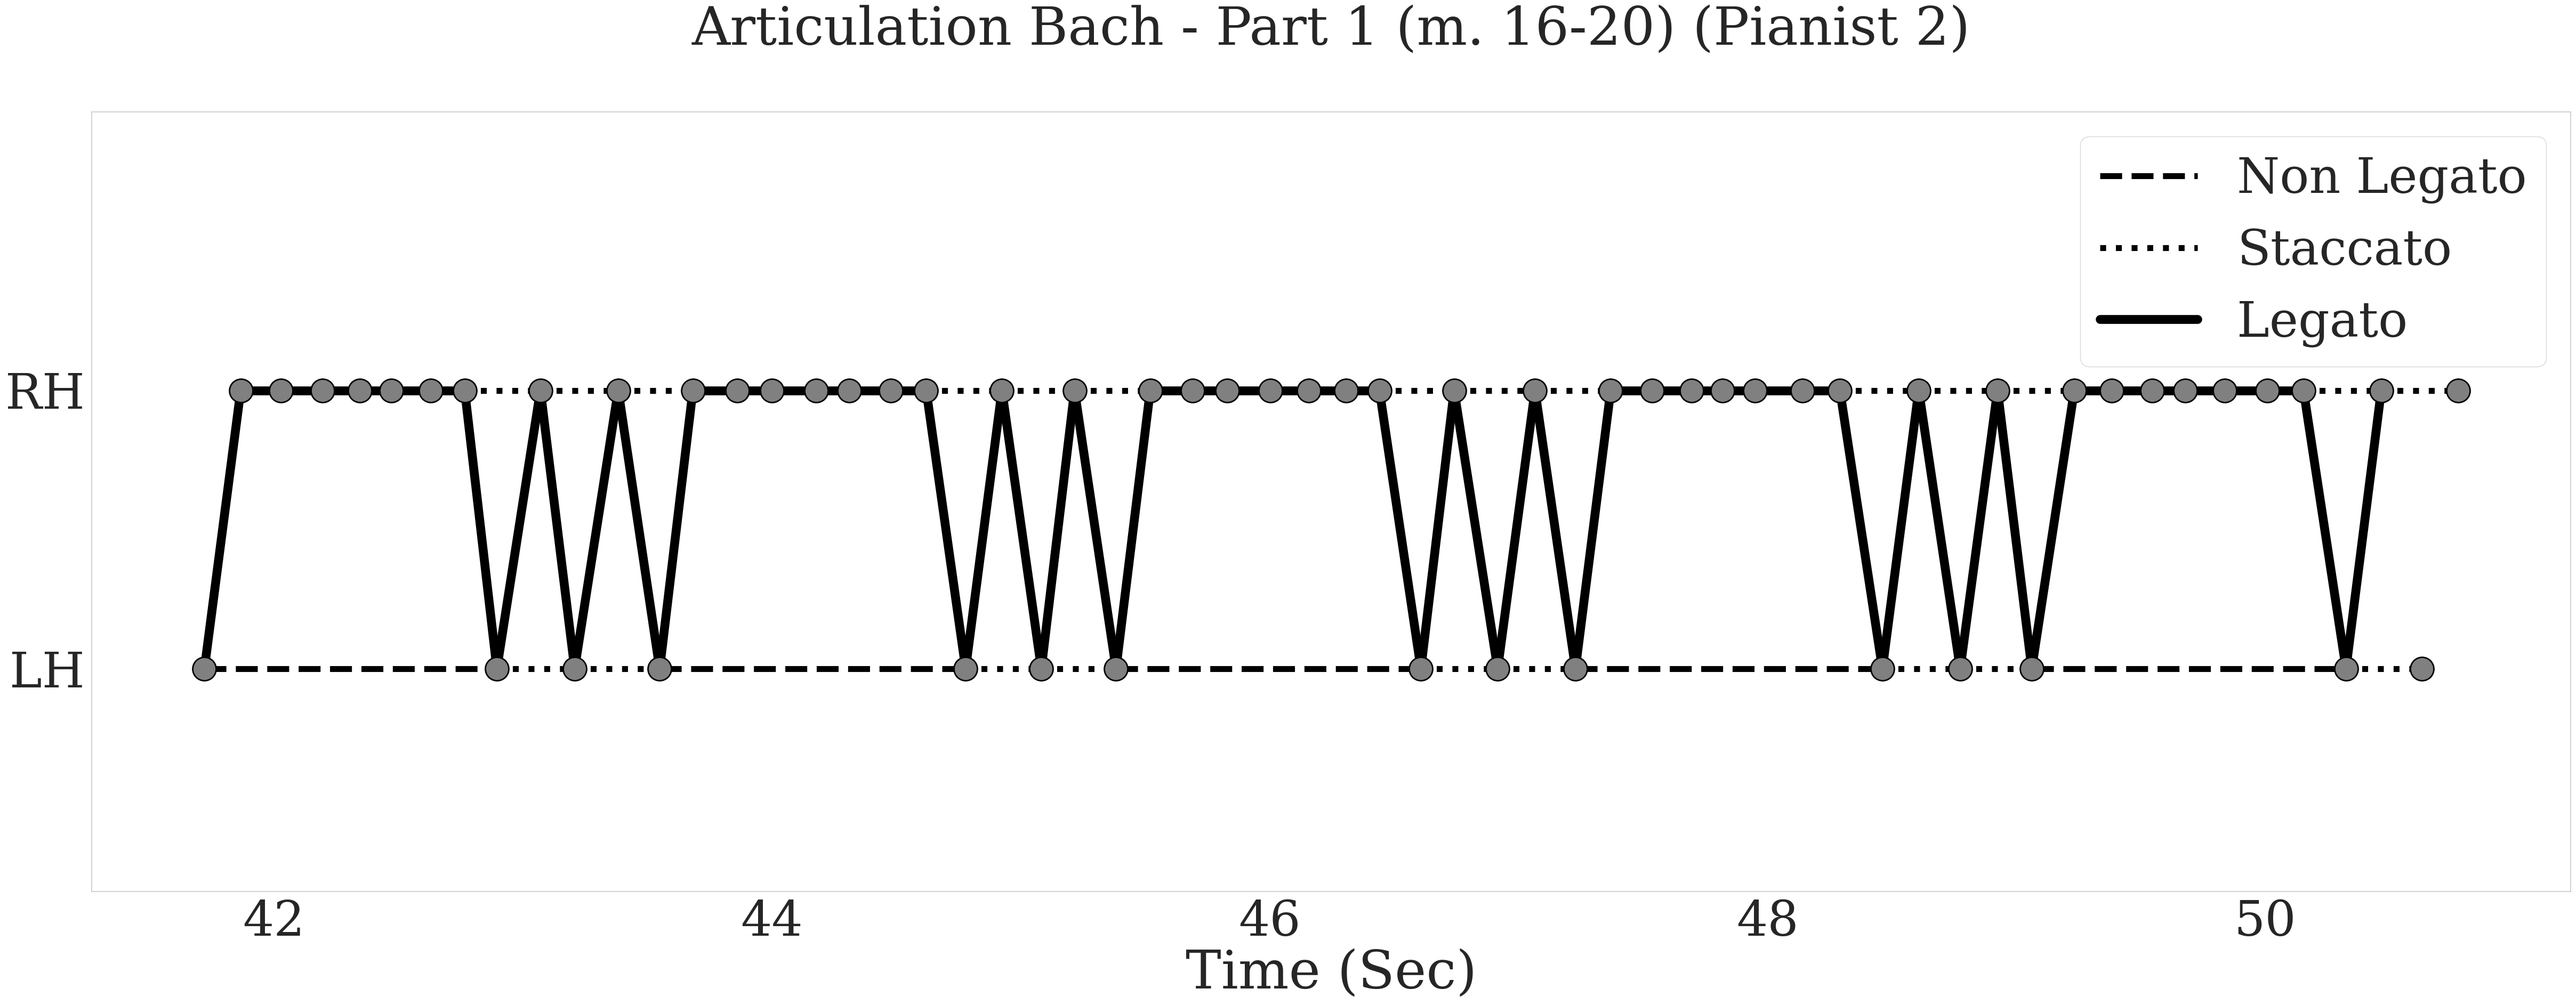

In [246]:
print_articulation_bach(df_articulation_bach, df_midi, 
                                 color_dict, linewidth_dict, 
                                 linetype_dict)